## Import Modules

In [1]:
import pandas as pd
import numpy as np
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error,precision_score,accuracy_score,classification_report
from sklearn.model_selection import KFold, train_test_split
from sklearn.grid_search import GridSearchCV
import math
%matplotlib inline

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Read and Clean Data

#### Import NBA advanced shot logs from 2013-2014 and 2014-2015 seasons.

In [2]:
shots = pd.read_csv('total_shots.csv')
del shots['Unnamed: 0']

In [3]:
#Analyze shots that have no negative touch time (impossible)
shots=shots[shots['touch_time']>=0]
#Remove shots that are over 40 feet
shots=shots[shots['shot_dist']<40]

#Remove any shot clock observations that are N/A
nan=float('nan')
shots=shots[~np.isnan(shots['shot_clock'])]

#Remove any shots that registered as N/A
nan=float('nan')
shots=shots[~np.isnan(shots['fgm'])]

#Remove any shots that have a closest defender distance over 30
shots=shots[shots['close_def_dist']<30]

#### Creating New Features

In [4]:
#Create new column that incorporates time and minutes into one column since they do not make sense in separate columns
shots['time_remaining'] = (shots['minutes_remaining']) + (shots['seconds_remaining'] * 0.01)

In [5]:
shots.loc[(shots['fgm'] == 2,'fgm')] = 1

In [6]:
#Convert 65 types of shots into 6 buckets of shot types. HP Shot = High Percentage Shot, Hard Jump Shot = More difficult jumpshots
shots.loc[(shots['action_type'].str.contains('Jump Shot'),'action_type')] = 'jump_shot'
shots.loc[(shots['action_type'].str.contains('Dunk'),'action_type')] = 'hp_shot'
shots.loc[(shots['action_type'].str.contains('Layup'),'action_type')] = 'hp_shot'
shots.loc[(shots['action_type'].str.contains('Hook'),'action_type')] = 'hook'
shots.loc[(shots['action_type'].str.contains('Driving'),'action_type')] = 'driving_shot'
shots.loc[(shots['action_type'].str.contains('Bank'),'action_type')] = 'bank_shot'
shots.loc[(shots['action_type'].str.contains('Tip'),'action_type')] = 'tip_shot'
shots.loc[(shots['action_type'].str.contains('Pullup'),'action_type')] = 'hard_jump_shot'
shots.loc[(shots['action_type'].str.contains('Running'),'action_type')] = 'hard_jump_shot'
shots.loc[(shots['action_type'].str.contains('Turnaround'),'action_type')] = 'hard_jump_shot'
shots.loc[(shots['action_type'].str.contains('Step Back'),'action_type')] = 'hard_jump_shot'
shots.loc[(shots['action_type'].str.contains('Floating'),'action_type')] = 'hard_jump_shot'
shots.loc[(shots['action_type'].str.contains('Fadeaway'),'action_type')] = 'hard_jump_shot'

In [7]:
#Delete shot type that are 'no shot' action types
shots = shots[shots.action_type != 'No Shot']

In [8]:
#Create dummy variables for shot types
shots_ML = pd.get_dummies(shots['action_type'])

In [9]:
#Create new dataframe with dummy variables inserted
newdf= pd.concat([shots,shots_ML], axis=1)

In [10]:
shots = shots.round(3)

In [11]:
shots.dtypes

closest_defender               object
closest_defender_player_id    float64
close_def_dist                float64
dribbles                      float64
fgm                           float64
final_margin                  float64
game_clock                     object
game_id                         int64
game_id.1                       int64
location                       object
matchup                        object
period                        float64
period.1                      float64
pts                           float64
pts_type                      float64
shot_clock                    float64
shot_dist                     float64
shot_number                   float64
shot_result                    object
touch_time                    float64
w                              object
grid_type                      object
game_event_id                 float64
player_id                     float64
player_id.1                     int64
player_name                    object
team_id     

## Statistical Models

#### Logistic Regression

In [12]:
smf.logit(formula='shot_made_flag ~ close_def_dist', data=shots).fit().summary()

Optimization terminated successfully.
         Current function value: 0.689253
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         shot_made_flag   No. Observations:               379731
Model:                          Logit   Df Residuals:                   379729
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Mar 2017   Pseudo R-squ.:               3.565e-05
Time:                        20:57:40   Log-Likelihood:            -2.6173e+05
converged:                       True   LL-Null:                   -2.6174e+05
                                        LLR p-value:                 1.560e-05
==================================================================================
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         -0.1544      0.006    -25.643      0.000        -0.166    -0.143
close_def_dist    -0.0053      0.001     -4.318      0.000        -0.008    -0.003
==================================================================================
"""

Though the closest defender distance has a p-value that is significant, the model is not a good fit because the variable of closest defender distance doesn't really show a relationship with a shot being made. The pseudo R-squared is terribly low

In [27]:
smf.logit(formula='shot_made_flag ~ close_def_dist+shot_distance+shot_clock+ touch_time+shot_number+final_margin', data=shots).fit().summary()

Optimization terminated successfully.
         Current function value: 0.660568
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         shot_made_flag   No. Observations:               379731
Model:                          Logit   Df Residuals:                   379724
Method:                           MLE   Df Model:                            6
Date:                Wed, 08 Mar 2017   Pseudo R-squ.:                 0.04165
Time:                        21:08:06   Log-Likelihood:            -2.5084e+05
converged:                       True   LL-Null:                   -2.6174e+05
                                        LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         -0.0549      0.012     -4.516      0.000        -0.079    -0.031
close_def_dist     0.0898      0.002     57.504      0.000         0.087     0.093
shot_distance     -0.0532      0.000   -121.359      0.000        -0.054    -0.052
shot_clock         0.0175      0.001     28.984      0.000         0.016     0.019
touch_time        -0.0384      0.001    -31.121      0.000        -0.041    -0.036
shot_number        0.0045      0.001      6.238      0.000         0.003     0.006
final_margin       0.0096      0.000     38.652      0.000         0.009     0.010
==================================================================================
"""

This logistic regression with more features is a bit better, but doesn't have a strong pseudo r-squared.

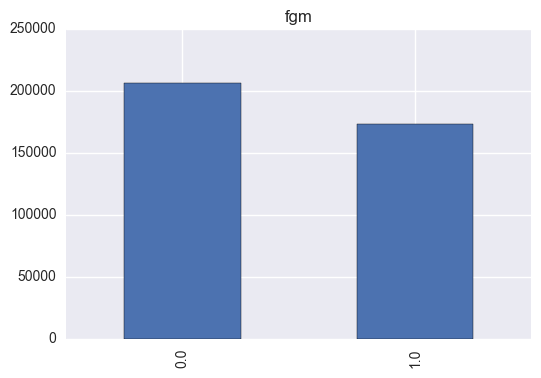

In [28]:
shots.fgm.value_counts().plot(kind='bar', title='fgm');

#### GLM 

In [29]:
results = smf.glm('shot_made_flag ~ close_def_dist+shot_distance+shot_clock+ touch_time+shot_number+final_margin', 
              data=shots, 
              family=sm.families.Binomial()).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         shot_made_flag   No. Observations:               379731
Model:                            GLM   Df Residuals:                   379724
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -2.5084e+05
Date:                Wed, 08 Mar 2017   Deviance:                   5.0168e+05
Time:                        21:08:09   Pearson chi2:                 3.80e+05
No. Iterations:                     7                                         
==================================================================================
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         -0.0549      0.012     -4.516      0.000        -0.079    -0.031
close_def_dist     0.0898      0.002     57.504      0.000         0.087     0.093
shot_distance     -0.0532      0.000   -121.359      0.000        -0.054    -0.052
shot_clock         0.0175      0.001     28.984      0.000         0.016     0.019
touch_time        -0.0384      0.001    -31.121      0.000        -0.041    -0.036
shot_number        0.0045      0.001      6.238      0.000         0.003     0.006
final_margin       0.0096      0.000     38.652      0.000         0.009     0.010
==================================================================================
"""

The GLM model is exactly the same as the previous logistic regression model because are both using the logit function.

In [32]:
explanatory_vars = list(newdf.columns)
explanatory_vars = [e for e in explanatory_vars]

In [33]:
X = newdf[[
 'close_def_dist',
 'shot_clock',
 'shot_number',
 'touch_time',
 'shot_distance']]
Y = newdf['shot_made_flag']

In [34]:
lm = LogisticRegression()
lm = lm.fit(X,Y)
lm.score(X,Y)

0.60682430457350067

In [35]:
Y.mean()

0.4560438836966168

60.7% accuracy is alright, but null error rate is 54.4%, which means we could get 54.4% accuracy by always predicting that a shot is not made.

#### Logistic Regression with New Features

In [62]:
X = newdf[['touch_time',
  'final_margin', 
  'shot_number',
  'shot_clock',
   'shot_distance',
'time_remaining',
 'close_def_dist',
 'bank_shot',
 'driving_shot',
 'hard_jump_shot',
 'hook',
 'hp_shot',
 'jump_shot',
 'tip_shot']]
Y = newdf['shot_made_flag']

In [63]:
lm2 = LogisticRegression()
lm2 = lm2.fit(X,Y)
lm2.score(X,Y)

0.63428584971993329

I created dummy variables to convert the categorical feature of shot type into numeric data. The accuracy score of this logistic regression is 63.5% which is better than our previous model of 60.5%. Considering that the null error rate is 54.4%, this is a pretty decent model.

In [106]:
lm2.intercept_

array([-0.14199111])

In [109]:
cols= X.columns.tolist()
coef= lm2.coef_[0].tolist()
A = pd.DataFrame({"X":cols})
A["Coef"] = coef
A

,X,Coef
0,touch_time,-0.046049
1,final_margin,0.009141
2,shot_number,0.004238
3,shot_clock,0.013431
4,shot_distance,-0.011637
5,time_remaining,0.000692
6,close_def_dist,0.086684
7,bank_shot,0.646833
8,driving_shot,-0.119704
9,hard_jump_shot,0.185055


Positive coefficients increase the log-odds of the response, and negative coefficients decrease the log-odds of the response.

In [110]:
logodds = lm2.intercept_ + lm2.coef_[0]
logodds

array([-0.18804045, -0.13285057, -0.13775325, -0.12856019, -0.15362829,
       -0.14129929, -0.05530742,  0.50484198, -0.26169489,  0.043064  ,
       -0.13708184,  0.2490336 , -0.94278535, -0.59130641])

In [111]:
odds = np.exp(logodds)
odds

array([ 0.82858119,  0.87559592,  0.87131366,  0.87936064,  0.85759073,
        0.86822942,  0.94619422,  1.65672371,  0.76974584,  1.04400471,
        0.87189887,  1.28278513,  0.38954131,  0.55360358])

In [112]:
prob = odds/(1 + odds)
prob

array([ 0.45312792,  0.46683612,  0.46561604,  0.46790415,  0.46166829,
        0.46473383,  0.48617667,  0.62359654,  0.43494711,  0.51076434,
        0.46578311,  0.56193862,  0.28033806,  0.35633516])

#### Split Data into Training and Testing sets for Classification

In [38]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=64)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
# predict class labels for the test set
predicted = model2.predict(X_test)
predicted

array([ 0.,  1.,  1., ...,  0.,  0.,  1.])

In [40]:
# generate class probabilities
probs = model2.predict_proba(X_test)
probs

array([[ 0.68524993,  0.31475007],
       [ 0.45215861,  0.54784139],
       [ 0.37820953,  0.62179047],
       ..., 
       [ 0.61325663,  0.38674337],
       [ 0.6621166 ,  0.3378834 ],
       [ 0.24770234,  0.75229766]])

In [41]:
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.635384480337
0.670352977755


In [85]:
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

[[45088 16787]
 [24750 27295]]
             precision    recall  f1-score   support

        0.0       0.65      0.73      0.68     61875
        1.0       0.62      0.52      0.57     52045

avg / total       0.63      0.64      0.63    113920



In [87]:
scores = cross_val_score(LogisticRegression(), X, Y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[ 0.63367041  0.6257966   0.64133354  0.63195871  0.63421378  0.63329208
  0.63208069  0.63841778  0.63949752  0.63101759]
0.63412787026


In [39]:
models = []
models.append(('LogR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=15, random_state=64)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LogR: 0.629902 (0.003694)
KNN: 0.594343 (0.003569)
CART: 0.563039 (0.002823)


#### Testing out a basic XGBoost Model

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


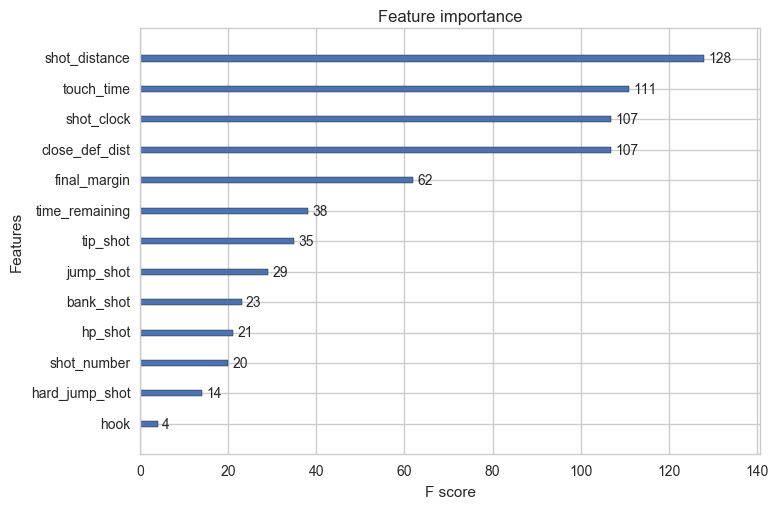

In [88]:
model = XGBClassifier()
model.fit(X,Y)
sns.set(style="whitegrid", color_codes=True, font_scale = 1)
# plot feature importance
plot_importance(model)
pyplot.show()

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3,random_state = 64)

xgb_model = XGBClassifier().fit(X_train,y_train)
predictions = xgb_model.predict(X_test)
actuals = y_test
print(confusion_matrix(actuals, predictions))
print(precision_score(actuals, predictions) )

[[49184 12691]
 [27557 24488]]
0.658651389225
